In [80]:
import sys,os,copy,glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from walker.hiscore import Hiscore
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
from smodels.tools.physicsUnits import fb
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from names import particleLabels
from sparticleNames import SParticleNames
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))
# sns.set_palette(sns.color_palette("deep"))
from smodels.tools import smodelsLogging
smodelsLogging.setLogLevel('error')

In [112]:
#Set colors:
namer = SParticleNames ( susy = False )
#Replace default colors:
colorPalette = 'deep' #Set color palette for particles, if None use default
colorDict = dict(zip(namer.names.keys(),sns.color_palette(palette=colorPalette,n_colors=len(namer.names))))
colors = sns.color_palette(palette=colorPalette,n_colors=10)

In [3]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict


In [4]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

In [5]:
#Get highest score model:
protomodel = None
for ff in glob.glob('../data/real*.dict'):
    with open(ff,'r') as f:
        pList = eval(f.read())
    run = eval(os.path.basename(ff).replace('real','').replace('.dict',''))
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    if (protomodel is None) or (protomodel.K < p.K):
        protomodel = copy.deepcopy(p)

In [6]:
print(protomodel)

ProtoModel (XZ1,Xd,Xt): K = 6.90, Z = 3.24


In [7]:
for pids, ssm in protomodel.ssmultipliers.items():
    if not ssm: continue
    print(pids,ssm)
print(protomodel.masses)    

(1000022, 1000022) 0.003
(1000001, 1000001) 0.493
(-1000001, 1000001) 0.492
(-1000001, -1000001) 0.493
(1000001, 1000022) 0.493
(-1000001, 1000022) 0.493
(1000006, 1000006) 1.325
(-1000006, 1000006) 1.226
(-1000006, -1000006) 1.11
(1000006, 1000022) 1.226
(-1000006, 1000022) 1.11
(1000001, 1000006) 1.11
(-1000006, 1000001) 1.11
(-1000001, 1000006) 1.11
(-1000006, -1000001) 1.11
{1000022: 162.552, 1000001: 734.948, 1000006: 1165.865}


In [8]:
#Get predictions:
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
res = pred.predict(protomodel)
#Get contributions
m = Manipulator(protomodel)
hi = Hiscore(walkerid=0,save_hiscores=False,predictor=pred)   
hi.computeParticleContributions(m)
hi.computeAnalysisContributions(m)

muvals = np.linspace(-10,10,500)
print(protomodel)
llhDict = getLikelihoods(protomodel,muvals)

[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


[hiscore:0] computing contribution of Xt (1165.9): [1/2]


[combine:0] selected predictions down via SRs from 190 to 10.
[combine:0] sorting out subsets, reduced 109 -> 24 combinations.


combination #24/24 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[hiscore:0] when removing Xt, K changed: 6.901 -> 2.586 (-62.5%), Z: 3.237 -> 2.216 (100000 evts)
[hiscore:0] computing contribution of Xd (734.9): [2/2]
[combine:0] selected predictions down via SRs from 40 to 9.
[combine:0] sorting out subsets, reduced 8 -> 8 combinations.
[hiscore:0] when removing Xd, K changed: 6.901 -> 3.905 (-43.4%), Z: 3.237 -> 2.481 (100000 evts)
[hiscore:0] stored 2 particle contributions
[hiscore:0] Now computing analysis contributions
[hiscore:0] Recompute the score. Old one at K=6.90, Z=3.24
[hiscore:0] finished computing contributions
[hiscore:0] contributionsK of 0 reads 7.036143001096877
[hiscore:0] contributionsK of 1 reads 3.3085372634096144
[hiscore:0] contributionsK of 2 reads 4.437114326356055
[hiscore:0] contributionsK of 3 reads 6.341210189286495
[hiscore:0] contributionsK of 4 reads 4.328802956473696
[hiscore:0] stored 5 analyses contributions
ProtoModel (XZ1,Xd,Xt): K = 6.90, Z = 3.24


In [9]:
sortedKeys = []
for key in llhDict.keys():
    if key == 'SM values' or key == 'Critic':
        continue
    else:
        sortedKeys.append((llhDict[key].max()/llhDict['SM values'][key],key))
sortedKeys = sorted(sortedKeys,reverse=True)
sortedKeys = [pt[1] for pt in sortedKeys]

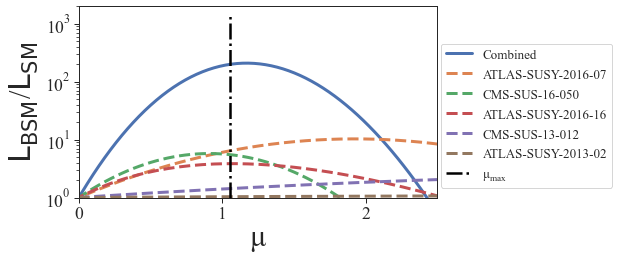

In [10]:
fig = plt.figure(figsize=(9,4))
for key in sortedKeys:
    val = llhDict[key]
    if key == 'Combined': ls = '-'
    else: ls = '--'
    plt.plot(muvals,val/llhDict['SM values'][key],label=key,linestyle=ls,linewidth=3)

plt.axvline(x=protomodel.mumax,ymax=0.95,c='black',linestyle='-.',label=r'$\mathdefault{\mu_{max}}$',
               linewidth=2.5)
plt.xticks(np.linspace(0,5,6))
plt.xlabel(r'$\mathdefault{\mu}$',fontsize=30)
plt.ylabel(r'$\mathdefault{\mathrm{L}_{\mathrm{BSM}}/\mathrm{L}_{\mathrm{SM}}}$',fontsize=30)
plt.legend(loc=(1.01,0.05),framealpha=1,fontsize=13,labelspacing=0.6)
plt.xlim(0,2.5)
plt.ylim(1,2e3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('winner_likelihood.pdf')
plt.savefig('winner_likelihood.png')
plt.show()

In [11]:
p = protomodel
print('\n run %i: K = %1.2f, Z = %1.2f, muhat = %1.2f, mumax = %1.2f' %(run,p.K,p.Z,p.muhat,p.mumax))
print('\t Best Combo:')
for tp in sorted(p.bestCombo, key = lambda tp: tp.expResult.globalInfo.id):
    if tp.dataset.dataInfo.dataType == 'efficiencyMap':
        print('\t\t',tp.expResult.globalInfo.id,tp.txnames,tp.dataset.dataInfo.dataId,
          tp.dataset.dataInfo.observedN,tp.dataset.dataInfo.expectedBG,tp.dataset.dataInfo.bgError)
        print('\t\t  prediction = %1.2f' %(tp.xsection.value*tp.expResult.globalInfo.lumi))
    else:
        print('\t\t',tp.expResult.globalInfo.id,tp.txnames,tp.getUpperLimit(),tp.getUpperLimit(expected=True))
        print('\t\t  prediction = ',tp.xsection.value.asNumber(fb)*fb)
print('\t Constraints:')
for tp in sorted(p.tpList, key = lambda x: x[0], reverse=True):
    if tp[0] < 0.5: continue
    print('\t\t r = %1.2f\n' %tp[0],tp[2].expResult.globalInfo.id,tp[2].dataset.dataInfo.dataType,tp[2].txnames,
          'theory xsec =  %1.2f, UL = %s, UL_exp = %s\n' 
          %(tp[2].xsection.value.asNumber(fb),tp[2].getUpperLimit(),tp[2].getUpperLimit(expected=True)))
print('\t Particle Contributions:')
for pid,cont in p.particleContributions.items():
    print('\t\t',pid,cont)

print('\t Analysis Contributions:')
for ana,cont in p.analysisContributions.items():
    print('\t\t',ana,cont)


 run 10: K = 6.90, Z = 3.24, muhat = 1.00, mumax = 1.06
	 Best Combo:
		 ATLAS-SUSY-2013-02 [T2] SR6jtp 6 4.9 1.6
		  prediction = 0.25
		 ATLAS-SUSY-2016-07 [T2] 2j_Meff_1200 611.0 526.0 31.0
		  prediction = 44.16
		 ATLAS-SUSY-2016-16 [T2tt] tN_high 8 3.8 1
		  prediction = 3.93
		 CMS-SUS-13-012 [T2] 3.08E+01 [fb] 1.96E+01 [fb]
		  prediction =  2.66E+00 [fb]
		 CMS-SUS-16-050 [T2tt] 4.50E+00 [fb] 2.50E+00 [fb]
		  prediction =  2.62E+00 [fb]
	 Constraints:
		 r = 1.30
 CMS-SUS-19-006 upperLimit [T2] theory xsec =  23.95, UL = 1.85E+01 [fb], UL_exp = 2.16E+01 [fb]

		 r = 1.28
 CMS-SUS-19-006 upperLimit [T2tt] theory xsec =  2.62, UL = 2.04E+00 [fb], UL_exp = 2.08E+00 [fb]

		 r = 1.24
 CMS-SUS-16-033 upperLimit [T2] theory xsec =  23.95, UL = 1.93E+01 [fb], UL_exp = 2.83E+01 [fb]

		 r = 0.92
 CMS-SUS-16-036 upperLimit [T2] theory xsec =  23.95, UL = 2.60E+01 [fb], UL_exp = 3.18E+01 [fb]

		 r = 0.90
 CMS-SUS-16-051 upperLimit [T2tt] theory xsec =  2.62, UL = 2.91E+00 [fb], UL_ex

In [12]:
mXt = np.linspace(900.,1400.,50)
pList = []
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
for mass in mXt:
    pnew = copy.deepcopy(protomodel)
    pnew.masses[1000006] = mass
    #Get predictions:
    res = pred.predict(pnew)
    pList.append(pnew)
    print(mass,pnew.K)

[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:14


900.0 1.1181675589789561


[combine:0] selected predictions down via SRs from 236 to 17.
[combine:0] sorting out subsets, reduced 990 -> 108 combinations.


combination #108/108 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:07


910.204081632653 1.2164809145853424


[combine:0] selected predictions down via SRs from 236 to 17.
[combine:0] sorting out subsets, reduced 990 -> 108 combinations.


combination #108/108 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:07


920.4081632653061 1.2368091982151457


[combine:0] selected predictions down via SRs from 238 to 17.
[combine:0] sorting out subsets, reduced 990 -> 108 combinations.


combination #108/108 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


930.6122448979592 2.5331239989272287


[combine:0] selected predictions down via SRs from 238 to 17.
[combine:0] sorting out subsets, reduced 990 -> 108 combinations.


combination #108/108 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


940.8163265306123 2.714353578766053


[combine:0] selected predictions down via SRs from 236 to 16.
[combine:0] sorting out subsets, reduced 919 -> 96 combinations.


combination #96/96 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


951.0204081632653 2.8884191794852168


[combine:0] selected predictions down via SRs from 234 to 16.
[combine:0] sorting out subsets, reduced 919 -> 96 combinations.


combination #96/96 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


961.2244897959183 2.939571366504179


[combine:0] selected predictions down via SRs from 234 to 16.
[combine:0] sorting out subsets, reduced 919 -> 96 combinations.


combination #96/96 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


971.4285714285714 3.1592440952669048


[combine:0] selected predictions down via SRs from 234 to 16.
[combine:0] sorting out subsets, reduced 919 -> 96 combinations.


combination #96/96 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


981.6326530612245 3.3560637168732326


[combine:0] selected predictions down via SRs from 234 to 16.
[combine:0] sorting out subsets, reduced 919 -> 96 combinations.


combination #96/96 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


991.8367346938776 3.537275600430915


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 608 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


1002.0408163265306 3.7030713362918313


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 608 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


1012.2448979591836 3.8632843867199496


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1022.4489795918367 4.108393674791575


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1032.6530612244899 4.351333842032686


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


1042.857142857143 4.608002102022664


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


1053.061224489796 4.798957271692866


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1063.265306122449 5.082763453932567


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1073.4693877551022 5.323730211658568


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1083.6734693877552 5.48999386791541


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1093.8775510204082 5.774289614534786


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1104.0816326530612 5.917575732250893


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1114.2857142857142 6.051586545937867


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1124.4897959183672 6.198995799058975


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1134.6938775510205 6.314558141943853


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1144.8979591836735 6.475913566781993


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1155.1020408163265 6.669439295075107


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1165.3061224489795 6.8958449363183645


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1175.5102040816328 6.9721117545202995


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1185.7142857142858 6.959721924751988


[combine:0] selected predictions down via SRs from 202 to 14.
[combine:0] sorting out subsets, reduced 465 -> 36 combinations.


combination #36/36 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1195.9183673469388 6.880944692285799


[combine:0] selected predictions down via SRs from 202 to 14.
[combine:0] sorting out subsets, reduced 465 -> 36 combinations.


combination #36/36 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1206.1224489795918 6.8235581778716705


[combine:0] selected predictions down via SRs from 200 to 13.
[combine:0] sorting out subsets, reduced 322 -> 36 combinations.


combination #36/36 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


1216.3265306122448 6.6642030687191225


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1226.5306122448978 5.358424125543846


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1236.734693877551 5.148358515774478


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1246.938775510204 5.00599398662163


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


1257.142857142857 4.855298232139529


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1267.3469387755101 4.842646498848938


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1277.5510204081634 4.7540928713108785


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1287.7551020408164 4.719983835085327


[combine:0] selected predictions down via SRs from 198 to 12.
[combine:0] sorting out subsets, reduced 275 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1297.9591836734694 4.646607753065983


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1308.1632653061224 2.653821427821514


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1318.3673469387754 2.528484911569814


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1328.5714285714284 2.4060588297560788


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1338.7755102040817 2.3294519642138143


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1348.9795918367347 2.341311666030368


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1359.1836734693877 2.3090314337222626


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1369.3877551020407 2.217051027031867


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


1379.591836734694 2.2452050366996614


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


combination #30/30 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


1389.795918367347 2.134463043450171


[combine:0] selected predictions down via SRs from 196 to 11.
[combine:0] sorting out subsets, reduced 132 -> 30 combinations.


1400.0 2.104655081690499


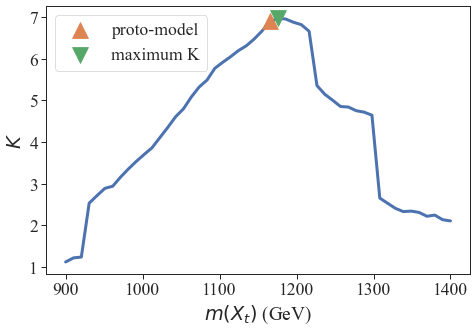

In [139]:
fig = plt.figure(figsize=(7,5))
kvalues = [pp.K for pp in pList]
plt.plot(mXt,kvalues,'-',linewidth=3,c=colors[0])
plt.scatter([protomodel.masses[1000006]],
            [protomodel.K],
            marker='^',s=250,label='proto-model',c=[colors[1]],zorder=10,alpha=1.0)
plt.scatter([mXt[np.argmax(kvalues)]],[kvalues[np.argmax(kvalues)]],
            marker='v',s=250,label='maximum K',c=[colors[2]],zorder=10,alpha=1.0)

plt.xlabel(r'$m(X_t)$ (GeV)')
plt.ylabel(r'$K$')
plt.legend()
plt.tight_layout()
plt.savefig('KvsMXt.pdf')
plt.show()

In [15]:
mZ = np.linspace(100.,400.,50)
pList2 = []
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
for mass in mZ:
    pnew = copy.deepcopy(protomodel)
    pnew.masses[1000022] = mass
    #Get predictions:
    res = pred.predict(pnew)
    pList2.append(pnew)

[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 202 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 204 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 204 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


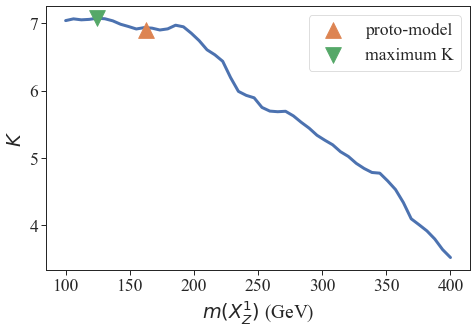

In [137]:
fig = plt.figure(figsize=(7,5))
kvalues = [pp.K for pp in pList2]
plt.plot(mZ,kvalues,'-',linewidth=3,c=colors[0])
plt.scatter([protomodel.masses[1000022]],
            [protomodel.K],
            marker='^',s=250,label='proto-model',c=[colors[1]],zorder=10,alpha=1.0)
plt.scatter([mZ[np.argmax(kvalues)]],[kvalues[np.argmax(kvalues)]],
            marker='v',s=250,label='maximum K',c=[colors[2]],zorder=10,alpha=1.0)

plt.xlabel(r'$m(X_Z^1)$ (GeV)')
plt.ylabel(r'$K$')
plt.legend()
plt.tight_layout()
plt.savefig('KvsMZ.pdf')
plt.show()

In [18]:
mD = np.linspace(600.,1000.,50)
pList3 = []
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
for mass in mD:
    pnew = copy.deepcopy(protomodel)
    pnew.masses[1000001] = mass
    #Get predictions:
    res = pred.predict(pnew)
    pList3.append(pnew)

[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 416 -> 48 combinations.


combination #48/48 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 210 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


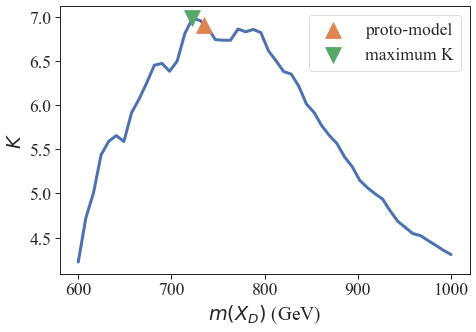

In [136]:
fig = plt.figure(figsize=(7,5))
kvalues = [pp.K for pp in pList3]
plt.plot(mD,kvalues,'-',linewidth=3,c=colors[0])
plt.scatter([protomodel.masses[1000001]],
            [protomodel.K],
            marker='^',s=250,label='proto-model',c=[colors[1]],zorder=10,alpha=1.0)
plt.scatter([mD[np.argmax(kvalues)]],[kvalues[np.argmax(kvalues)]],
            marker='v',s=250,label='maximum K',c=[colors[2]],zorder=10,alpha=1.0)

plt.xlabel(r'$m(X_D)$ (GeV)')
plt.ylabel(r'$K$')
plt.legend()
plt.tight_layout()
plt.savefig('KvsMD.pdf')
plt.show()

In [21]:
kappaD = np.linspace(0.2,0.7,50)
pList4 = []
for k in kappaD:
    pnew = copy.deepcopy(protomodel)
    for key in pnew.ssmultipliers:
        if 1000001 in key or -1000001 in key:
            pnew.ssmultipliers[key] = k
    #Get predictions:
    res = pred.predict(pnew)
    pList4.append(pnew)

[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


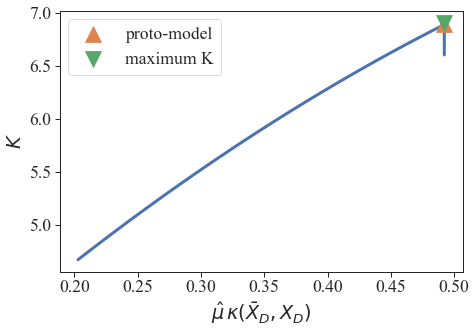

In [135]:
fig = plt.figure(figsize=(7,5))
kvalues = [pp.K for pp in pList4]
kappaEff = kappaD*np.array([p.muhat for p in pList4])
plt.plot(kappaEff[:-3],kvalues[:-3],'-',linewidth=3,c=colors[0])
plt.scatter([protomodel.muhat*protomodel.ssmultipliers[(-1000001,1000001)]],
            [protomodel.K],
            marker='^',s=250,label='proto-model',c=[colors[1]],zorder=10,alpha=1.0)
plt.scatter([kappaEff[np.argmax(kvalues)]],[kvalues[np.argmax(kvalues)]],
            marker='v',s=250,label='maximum K',c=[colors[2]],zorder=10,alpha=1.0)

plt.xlabel(r'$\hat{\mu}\, \kappa(\bar{X}_D,X_D)$')
plt.ylabel(r'$K$')
plt.legend()
plt.tight_layout()
plt.savefig('KvsKappaD.pdf')
plt.show()

In [23]:
kappaT = np.linspace(0.5,2.0,50)
pList5 = []
for k in kappaT:
    pnew = copy.deepcopy(protomodel)
    for key in pnew.ssmultipliers:
        if 1000006 in key or -1000006 in key:
            pnew.ssmultipliers[key] = k
    #Get predictions:
    res = pred.predict(pnew)
    pList5.append(pnew)

[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


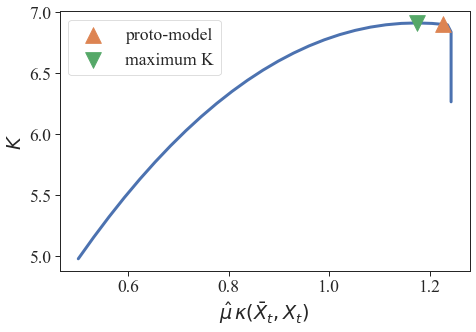

In [134]:
fig = plt.figure(figsize=(7,5))
kvalues = [pp.K for pp in pList5]
kappaEff = kappaT*np.array([p.muhat for p in pList5])
plt.plot(kappaEff[:-15],kvalues5[:-15],'-',linewidth=3,c=colors[0])
plt.scatter([protomodel.muhat*protomodel.ssmultipliers[(-1000006,1000006)]],
            [protomodel.K],
            marker='^',s=250,label='proto-model',c=[colors[1]],zorder=10,alpha=1.0)
plt.scatter([kappaEff[np.argmax(kvalues)]],[kvalues[np.argmax(kvalues)]],
            marker='v',s=250,label='maximum K',c=[colors[2]],zorder=10,alpha=1.0)

plt.xlabel(r'$\hat{\mu}\, \kappa(\bar{X}_t,X_t)$')
plt.ylabel(r'$K$')
plt.legend()
plt.tight_layout()
plt.savefig('KvsKappaT.pdf')
plt.show()